# 6. Betting Simulator

In this notebook, we're going to use the betting dataframe built in the last stage, to simulate bets on matches where we think to have an edge on the betting market (i.e. a value bet occurs when the real odds for an event are higher than the odds "predicted" by our model).

Finally, we'll compare several betting strategies and we'll find out if it's possible to make a good ROI backtesting our betting strategies.

Let's import the relevant libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Let's import the Betting Dataframe saved in the last notebook

In [2]:
betting_df = pd.read_csv("csv/Betting_Data.csv")

In [3]:
betting_df

,Date,Player 0,Player 1,Winner,Pl0_Rank,Pl1_Rank,Pl0 Avg odds,Pl1 Avg odds,Pl1 Max odds,Pl0 Max odds,...,Pl0 Perf. vs Similar Opponent,Pl1 Perf. vs Similar Opponent,Pl0 Surface Performance,Pl1 Surface Performance,Pl0 %,Pl1 %,Fair odds for Pl0,Fair odds for Pl1,Bet on Pl0 Value,Bet on Pl1 Value
0,2010-04-19,De Bakker T.,Falla A.,0.0,67,58,1.52,2.46,2.79,1.62,...,0.50,0.39,0.46,0.39,0.619670,0.380330,1.61,2.63,-0.055901,-0.064639
1,2010-04-19,Starace P.,Hajek J.,1.0,61,86,1.34,3.12,3.64,1.40,...,0.52,0.40,0.52,0.39,0.671717,0.328283,1.49,3.05,-0.100671,0.022436
2,2010-04-19,Schwank E.,Fognini F.,0.0,59,74,1.99,1.77,1.85,2.14,...,0.46,0.60,0.45,0.58,0.326398,0.673602,3.06,1.48,-0.349673,0.163842
3,2010-04-19,Rochus C.,Garcia-Lopez G.,1.0,122,42,3.02,1.36,1.45,3.25,...,0.36,0.59,0.43,0.50,0.325714,0.674286,3.07,1.48,-0.016287,-0.081081
4,2010-04-19,Bellucci T.,Nieminen J.,0.0,33,64,1.46,2.63,3.09,1.50,...,0.57,0.46,0.53,0.53,0.521146,0.478854,1.92,2.09,-0.239583,0.205323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25349,2019-11-15,Nadal R.,Tsitsipas S.,0.0,1,6,1.41,2.93,3.30,1.48,...,0.50,0.67,0.67,0.80,0.262746,0.737254,3.81,1.36,-0.629921,0.535836
25350,2019-11-15,Medvedev D.,Zverev A.,1.0,4,7,1.90,1.92,2.24,2.06,...,0.00,1.00,0.00,0.50,0.019093,0.980907,52.38,1.02,-0.963727,0.468750
25351,2019-11-16,Tsitsipas S.,Federer R.,0.0,6,3,3.39,1.33,1.40,3.75,...,0.67,0.33,0.80,0.67,0.788123,0.211877,1.27,4.72,0.625369,-0.718220
25352,2019-11-16,Zverev A.,Thiem D.,1.0,7,5,2.06,1.78,1.87,2.20,...,0.00,0.33,0.50,0.60,0.254161,0.745839,3.93,1.34,-0.475827,0.247191


Now it's time to simulate the bets!!

We're going to start defining some functions that will place the bets and print informations like:
- number of bets placed, won and lost
- final margin between the initial bankroll and the bankroll after each bet has been placed
- total amount of money invested (sum of stakes)
- ROI, aka Return on Investment, expressed as: overall profit (or loss) / total amount of money invested

In [4]:
"""
This function simulates betting on value bets as defined in the dataframe where each bet is equal to the others 
and takes in input:
- the initial bankroll
- the stake (each bet has the same stake)
- a bet_on_max_odds variable, that defaults to True and it's the criteria based upon we decide to bet on the maximum
odds available or the average odds
"""
def betting_at_same_stake(initial_bankroll, stake, bet_on_max_odds=True):
    
    plot_df_list = []
    bankroll = initial_bankroll
    won_bets = 0
    lost_bets = 0
    total_bets = 0
    for ix, row in betting_df.iterrows():
        if bankroll < 0: break
        
        value_on_p0 = row['Bet on Pl0 Value']
        value_on_p1 = row['Bet on Pl1 Value']
        winner = row["Winner"]
        
        if ix % 100 == 0: plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
            
        if bet_on_max_odds: 
            real_odds_p0 = row['Pl0 Max odds']
            real_odds_p1 = row['Pl1 Max odds']
        else:
            real_odds_p0 = row['Pl0 Avg odds']
            real_odds_p1 = row['Pl1 Avg odds'] 
        
        if pd.isna(real_odds_p0) or pd.isna(real_odds_p1): continue
        
        if value_on_p0 > 0:
            total_bets += 1
            if winner == 0:
                bankroll += (real_odds_p0 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
        
        if value_on_p1 > 0:
            total_bets += 1
            if winner == 1:
                bankroll += (real_odds_p1 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
    
    plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
    profit = round(bankroll - initial_bankroll,2)
    investment = total_bets*stake
    roi = round(100 * profit / investment, 2)
    print("Total bets placed: {}\nBets won: {}, bets lost: {}\nProfit: {}\nMoney invested: {}\nROI: {}%"
           .format(total_bets, won_bets, lost_bets, profit, investment, roi))
    plot_df = pd.DataFrame(plot_df_list)
    plot_df.plot.line(x='Bets', y='Profit')

Total bets placed: 19808
Bets won: 10942, bets lost: 8866
Profit: 23602.95
Money invested: 99040
ROI: 23.83%


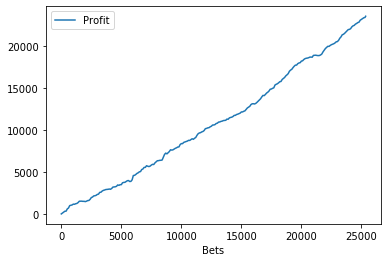

In [5]:
betting_at_same_stake(initial_bankroll=100, stake=5, bet_on_max_odds=True)

Wow! We obtained an impressive 23.83% ROI!

However, the first question that we have to ask ourself is: is this achievable in real life?!

Well, the answer is no. And the reason is simple: betting at the highest available odds for each match is simply not possible,
and the maximum odds in the dataframe are calculated between all of these bookmakers:

Bet365, Bet&Win, Centrebet, Expekt, Ladbrokes, Gamebookers, Interwetten, Pinnacles Sports, Sportingbet, Stan James and Unibet.

So, let's simulate the same betting behaviour but on the Average odds available for each player.
This way, we can achive a much more realistic outcome:

Total bets placed: 19808
Bets won: 10942, bets lost: 8866
Profit: 12230.65
Money invested: 99040
ROI: 12.35%


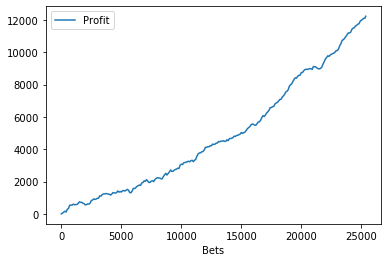

In [6]:
betting_at_same_stake(initial_bankroll=100, stake=5, bet_on_max_odds=False)

Well, the ROI has fallen from an impressive 23.83% to a much smaller 12.35%!

Is this a bad result?! Not at all!

In fact, risking only 5 units per bet, we started with a bankroll of 100 units and finished with more than 12000!
And now the odds were much easier to find!

## Where are the Bookmaker margins?

We already discussed about the fact that betting always at the highest available odds would just be impossible.
Let's calculate the bookmakers margin betting on the average odds and the maximum odds available for each match:

In [7]:
"""
This method calculates the mean bookmaker margin for each of the bets in the dataframe.
If parameter max_odds = True, the maximum odds are considered. Otherwise, the margin is calculated on the average odds.
"""
def bookmaker_margin(max_odds=True):
    total_margin = 0
    for ix, row in betting_df.iterrows():
        
        if max_odds: 
            odds_p0 = row['Pl0 Max odds']
            odds_p1 = row['Pl1 Max odds']
        else:
            odds_p0 = row['Pl0 Avg odds']
            odds_p1 = row['Pl1 Avg odds'] 
            
        total_margin += (1/odds_p0) + (1/odds_p1)
    
    return total_margin / betting_df.shape[0]

In [8]:
mean_book_margin_at_max_odds = bookmaker_margin(max_odds = True)
mean_book_margin_at_avg_odds = bookmaker_margin(max_odds = False)

In [9]:
mean_book_margin_at_max_odds

0.9965733894097268

In [10]:
mean_book_margin_at_avg_odds

1.0582522071928147

The mean bookmaker margin betting on the highest odds is so small that there isn't any margin!
In fact it's less than 1!

However, betting the average odds gives the bookmaker a mean margin around 6%, so very similar to the actual bookmakers margin that we can find in the "real" world.
This emphasizes the fact that achieving around 7% ROI betting on "real" odds is really remarkable.

## Other Betting Strategies

We know that betting the same amount of money on each bet is typical for occasional puntors. However, what about other betting strategies?
Since we know there's room for profit, why not explore several betting strategies and compare the results?
We'll analyze:
- Fibonacci betting strategy
- Martingale betting strategy
- Kelly's criterion


__Note__: from now on, we will use only the Average odds to achive a more realistic betting outcome.

### Fibonacci

Let's start with the Fibonacci betting strategy.
The Fibonacci betting system is a negative progression system, which means that you increase your wager each time you lose a bet.

Suppose we have the fibonacci sequence starting from 1:

1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, etc.

In practice:
- We choose 1 as initial stake and we make the first bet
- Every time you lose a bet, move one number to the right, every time you win a bet, move two numbers to the left.


Let's define the fibonacci method, using the golden rule.

In [11]:
from math import sqrt

#uses golden rule
def fibonacci(n):
    return round(((1+sqrt(5))**n-(1-sqrt(5))**n)/(2**n*sqrt(5)))

In [12]:
def betting_with_fibonacci(initial_bankroll):
    plot_df_list = []
    
    bankroll = initial_bankroll
    investment = 0
    won_bets = 0
    lost_bets = 0
    total_bets = 0
    current_fibonacci_index = 1
    for ix, row in betting_df.iterrows():
        if bankroll < 0: break
        
        value_on_p0 = row['Bet on Pl0 Value']
        value_on_p1 = row['Bet on Pl1 Value']
        winner = row["Winner"]
        
        if ix % 100 == 0: plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
            
        real_odds_p0 = row['Pl0 Avg odds']
        real_odds_p1 = row['Pl1 Avg odds'] 
        
        if pd.isna(real_odds_p0) or pd.isna(real_odds_p1): continue
        
        stake = fibonacci(current_fibonacci_index)
        
        if value_on_p0 > 0:
            total_bets += 1
            if winner == 0:
                bankroll += (real_odds_p0 - 1) * stake
                won_bets += 1
                current_fibonacci_index = max(1, current_fibonacci_index-2)
            else:
                bankroll -= stake
                lost_bets += 1
                current_fibonacci_index += 1
        
        if value_on_p1 > 0:
            total_bets += 1
            if winner == 1:
                bankroll += (real_odds_p1 - 1) * stake
                won_bets += 1
                current_fibonacci_index = max(1, current_fibonacci_index-2)
            else:
                bankroll -= stake
                lost_bets += 1
                current_fibonacci_index += 1

        investment += stake
    
    plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
    profit = round(bankroll - initial_bankroll,2)
    roi = round(100 * profit / investment, 2)
    print("Total bets placed: {}\nBets won: {}, bets lost: {}\nProfit: {}\nMoney invested: {}\nROI: {}%"
           .format(total_bets, won_bets, lost_bets, profit, investment, roi))
    plot_df = pd.DataFrame(plot_df_list)
    plot_df.plot.line(x='Bets', y='Profit')

Total bets placed: 38
Bets won: 17, bets lost: 21
Profit: -181.56
Money invested: 729
ROI: -24.91%


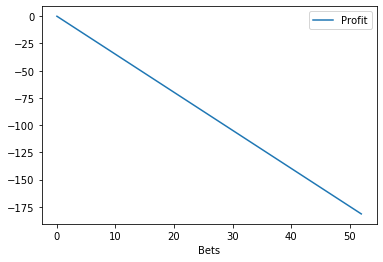

In [13]:
betting_with_fibonacci(100)

Well, that's not very incouraging!
After 38 bets, we've run out of money to bet! This is a recurring problem of the negative progression strategies like Fibonacci.

Let's see if with Martingale progression we are luckier!

### Martingale

This strategy defines a base minimum stake (we'll go with 1% of initial bankroll) and has only 2 rules:
- Double up every time you lose
- Stick to your base stake when you win

In [14]:
def betting_with_martingale(initial_bankroll):
    plot_df_list = []
    
    bankroll = initial_bankroll
    investment = 0
    won_bets = 0
    lost_bets = 0
    total_bets = 0
    
    initial_stake = round(initial_bankroll*1/100)
    stake = initial_stake
    
    for ix, row in betting_df.iterrows():
        if bankroll < 0: break
        
        value_on_p0 = row['Bet on Pl0 Value']
        value_on_p1 = row['Bet on Pl1 Value']
        winner = row["Winner"]
        
        if ix % 100 == 0: plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
            
        real_odds_p0 = row['Pl0 Avg odds']
        real_odds_p1 = row['Pl1 Avg odds'] 
        
        if pd.isna(real_odds_p0) or pd.isna(real_odds_p1): continue
            
        if value_on_p0 > 0:
            total_bets += 1
            if winner == 0:
                bankroll += (real_odds_p0 - 1) * stake
                won_bets += 1
                stake = initial_stake
            else:
                bankroll -= stake
                lost_bets += 1
                stake *= 2
        
        if value_on_p1 > 0:
            total_bets += 1
            if winner == 1:
                bankroll += (real_odds_p1 - 1) * stake
                won_bets += 1
                stake = initial_stake
            else:
                bankroll -= stake
                lost_bets += 1
                stake *= 2

        investment += stake
    
    plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
    profit = round(bankroll - initial_bankroll,2)
    roi = round(100 * profit / investment, 2)
    print("Total bets placed: {}\nBets won: {}, bets lost: {}\nProfit: {}\nMoney invested: {}\nROI: {}%"
           .format(total_bets, won_bets, lost_bets, profit, investment, roi))
    plot_df = pd.DataFrame(plot_df_list)
    plot_df.plot.line(x='Bets', y='Profit')

Total bets placed: 4042
Bets won: 2179, bets lost: 1863
Profit: -336.45
Money invested: 25760
ROI: -1.31%


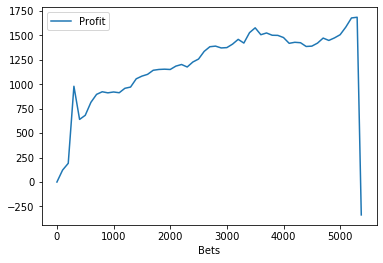

In [15]:
betting_with_martingale(100)

As we can see, at the first big losing streak we've lost all our money! Much like the Fibonacci strategy, the Martingale's risky approach didn't pay out at all!

### Kelly's Criterion

The Kelly Criterion is a mathematical formula that can be applied to determine the optimal sum of money that should be invested or wagered on an opportunity. It takes into consideration the total amount of money that's available to use and the expected return.

The formula to calculate the stake to use at each bet is the following:

(bp – q) / b = f

where:
- b is the multiple of your stake you can win from the wager: it's equal to the odds minus 1.
- p is the probability of the wager winning: the predicted chance to win the bet
- q is the probability of the wager losing: simply equals to 1 - p
- f is the fraction of your bankroll to stake on the wager

Let's define a function that takes in input the probability of an event to occur and its odds, and returns a fraction of the bankroll to invest based on the Kelly's criterion.

In [16]:
def kelly(prob, odds):
    return round((prob*odds - 1)/(odds - 1), 2)

Now it's time to define the function that simulates these bets using the Kelly's criterion.
However, we define a threshold for how a stake for each bet can be. This parameter, __max_stake_for_bet__, defaults to 100 but can be specified as input parameter of the function.

In [17]:
def betting_with_kelly(initial_bankroll, max_stake_for_bet=100):
    plot_df_list = []
    
    bankroll = initial_bankroll
    investment = 0
    won_bets = 0
    lost_bets = 0
    total_bets = 0
    
    for ix, row in betting_df.iterrows():
        if bankroll < 0: break
        
        value_on_p0 = row['Bet on Pl0 Value']
        value_on_p1 = row['Bet on Pl1 Value']
        winner = row["Winner"]
        
        if ix % 100 == 0: plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
            
        real_odds_p0 = row['Pl0 Avg odds']
        real_odds_p1 = row['Pl1 Avg odds'] 
        
        if pd.isna(real_odds_p0) or pd.isna(real_odds_p1): continue
            
        if value_on_p0 > 0:
            stake = min(max_stake_for_bet, round(bankroll * kelly(row['Pl0 %'], real_odds_p0)))
            if stake < 0: continue
            investment += stake
            total_bets += 1
            if winner == 0:
                bankroll += (real_odds_p0 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
        
        if value_on_p1 > 0:
            stake = min(max_stake_for_bet, round(bankroll * kelly(row['Pl1 %'], real_odds_p1)))
            if stake < 0: continue
            investment += stake
            total_bets += 1
            if winner == 1:
                bankroll += (real_odds_p1 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
        
    plot_df_list.append({"Bets":ix,"Profit":bankroll-initial_bankroll})
    profit = round(bankroll - initial_bankroll,2)
    roi = round(100 * profit / investment, 2)
    print("Total bets placed: {}\nBets won: {}, bets lost: {}\nProfit: {}\nMoney invested: {}\nROI: {}%"
           .format(total_bets, won_bets, lost_bets, profit, investment, roi))
    plot_df = pd.DataFrame(plot_df_list)
    plot_df.plot.line(x='Bets', y='Profit')

Total bets placed: 19808
Bets won: 10942, bets lost: 8866
Profit: 248376.14
Money invested: 1945034
ROI: 12.77%


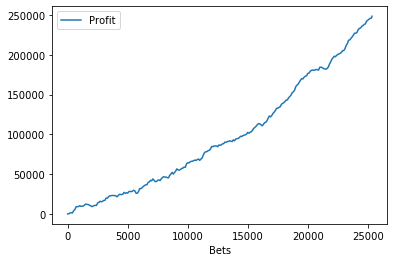

In [18]:
betting_with_kelly(100)

Well...This really is a remarkable result!
The ROI didn't change much, but the overall profit exploded :) 
That's becase Kelly's criterium is really helpful to pick the best amount of money to invest in each single bet!

It's clearly the best choice over the other betting strategies.

## Further analysis on value predictions

At this point, we should be pretty confident that our model does quite a good job at predicting the correct chances for each player to win a match.

However, what happens if, rather than betting blindly on every bet that has value greater than 0, we define a value threshold, like 0.10, 0.25, etc.?
How does this threshold affect the ROI?

Let's find out!

Let's define a function similar to the __betting_with_kelly__ used above, that takes in input this value threshold and returns the ROI:

In [19]:
def betting_with_kelly_and_threshold(initial_bankroll, VALUE_THRESHOLD, max_stake_for_bet=100):    
    bankroll = initial_bankroll
    investment = 0
    won_bets = 0
    lost_bets = 0
    total_bets = 0
    
    for ix, row in betting_df.iterrows():
        if bankroll < 0: break
        
        value_on_p0 = row['Bet on Pl0 Value']
        value_on_p1 = row['Bet on Pl1 Value']
        winner = row["Winner"]
                    
        real_odds_p0 = row['Pl0 Avg odds']
        real_odds_p1 = row['Pl1 Avg odds'] 
        
        if pd.isna(real_odds_p0) or pd.isna(real_odds_p1): continue
            
        if value_on_p0 > VALUE_THRESHOLD:
            stake = min(max_stake_for_bet, round(bankroll * kelly(row['Pl0 %'], real_odds_p0)))
            if stake < 0: continue
            investment += stake
            total_bets += 1
            if winner == 0:
                bankroll += (real_odds_p0 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
        
        if value_on_p1 > VALUE_THRESHOLD:
            stake = min(max_stake_for_bet, round(bankroll * kelly(row['Pl1 %'], real_odds_p1)))
            if stake < 0: continue
            investment += stake
            total_bets += 1
            if winner == 1:
                bankroll += (real_odds_p1 - 1) * stake
                won_bets += 1
            else:
                bankroll -= stake
                lost_bets += 1
        
    profit = round(bankroll - initial_bankroll,2)
    roi = round(100 * profit / investment, 2)
    return roi

Now, let's run this function with different value thresholds parameters, and let's compare the ROI for each run.

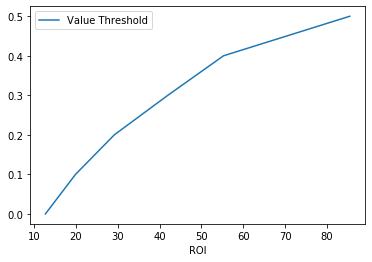

In [20]:
threshold_comparator_df_list = []
for i in np.linspace(start=0, stop=0.6, num=6, endpoint=False):
    value_threshold = round(i,1)
    roi = betting_with_kelly_and_threshold(100, VALUE_THRESHOLD=value_threshold)
    threshold_comparator_df_list.append({"Value Threshold":value_threshold, "ROI":roi})

threshold_comparator_df = pd.DataFrame(threshold_comparator_df_list)
threshold_comparator_df.plot.line(x='ROI', y='Value Threshold')

It's clear from the above image that there's a positive relationship between the Value Threshold and the Return on our Investement! 

The dropoff with choosing a greater threshold is, of course, that there are less and less opportunities and matches to bet on!

# Conclusion

It's been a long journey but we've come to an end!

Let's recap what we accomplished.
Firstly, we obtained a tennis match dataset containing almost every match between 2000 and 2019, with many important features defined such as surface, court, round of tournament, tournament's category, ranking of the players and average/max odds for each player for as many as around 25000 matches!

Then we preprocessed the data, and extended it calculating new features for each match like the surface perfomance for each player, the recent form of the players before their matches, how well they performed against opponents with similar rankings, etc.

With this extended dataset, we trained some machine learning models and we picked the best to predict the chances for each player to win any given match.

Using these probabilities, and comparing them to the max and average odds available, we found value bets.

So we used different betting strategies to backtest the model's predictions and their accuracy, and we've soon find out that using Kelly's criterion as betting strategy we could obtain a very high ROI, even with average odds, as we discussed in this notebook.

Thanks for your attention,
Andrea Corsetti